# Forecasting Exchange Rates Using Time Series Analysis

## Objective

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.

## Part 1: Data Preparation and Exploration

### 1. Data Loading

In [1]:
import pandas as pd

df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


### 2. Initial Exploration

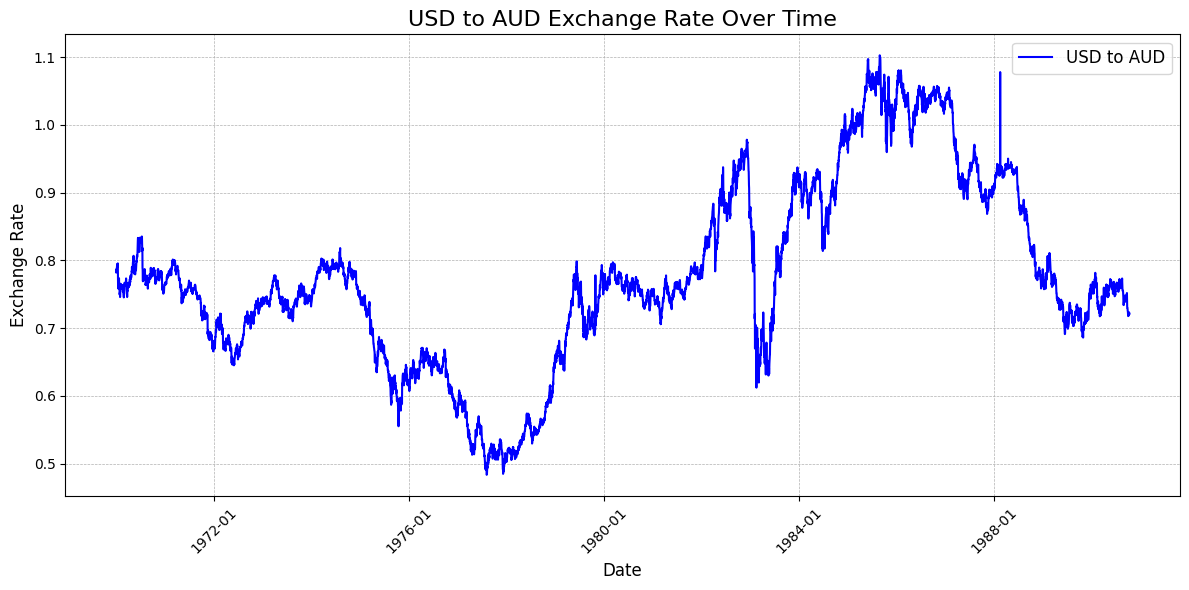

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))  # Increase figure size for better clarity
plt.plot(df['date'], df['Ex_rate'], label='USD to AUD', color='blue')  # Customize line color

# Set title and labels with larger font sizes
plt.title('USD to AUD Exchange Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Rotate date labels and format them for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as per your date range
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust the tick positions

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend with a slightly larger font
plt.legend(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()


Here are a few key insights based on the visual:

1. **Volatility**: The exchange rate fluctuates significantly over time, showing periods of both upward and downward trends.
2. **Major Peaks**: There are noticeable peaks, particularly around the 1.1 mark, indicating a strong USD relative to the AUD during certain periods.
3. **Periods of Decline**: There are significant declines in the exchange rate, most notably when it dips below 0.6, reflecting a period when the AUD was stronger relative to the USD.
4. **Recent Stability**: Toward the end of the chart, the exchange rate appears to stabilize, although it is still fluctuating below 0.8.

### 3. Data Preprocessing

In [3]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


- No missing values found
- No data inconsistencies found

## Part 2: Model Building - ARIMA

### 1. Parameter Selection for ARIMA

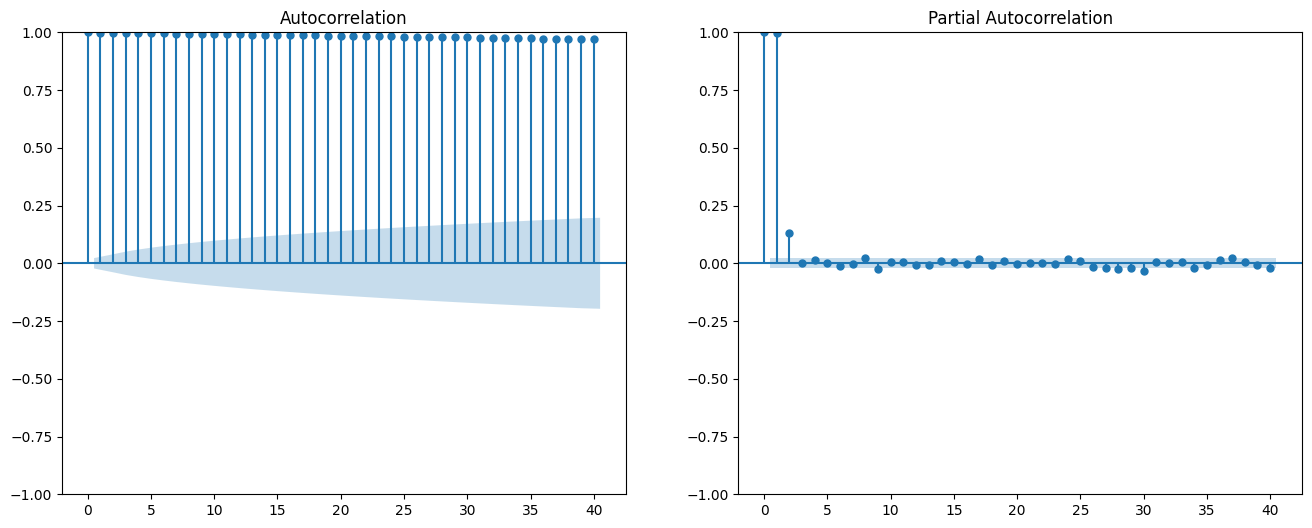

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(df['Ex_rate'], lags=40, ax=axes[1])
plt.show()

#### Key Insights:

1. **Autocorrelation (ACF) Plot (Left)**:
   - **Strong autocorrelation**: The autocorrelation remains very high across all lags, close to 1, indicating that the time series is highly correlated with its past values.
   - This suggests the presence of a trend or non-stationarity in the data.
   - **Tapering off**: The autocorrelation gradually decreases but stays within the confidence interval, which implies that the series has a long memory or strong persistence over time.

2. **Partial Autocorrelation (PACF) Plot (Right)**:
   - **Sharp cut-off** after lag 1: The partial autocorrelation drops significantly after lag 1, indicating that the time series may be explained well by an AR(1) process.
   - **Near-zero correlations** after lag 1 suggest that beyond this lag, the series does not show much dependency on past values, except for the immediate previous values.
   
#### Overall Interpretation:
- The ACF plot indicates strong non-stationarity, meaning that the time series has trends or persistent patterns.
- The PACF plot suggests that an AR(1) model might be appropriate for capturing the structure of the data, as the significant autocorrelation is seen only at lag 1.


### 2. Model Fitting

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sun, 22 Sep 2024   AIC                         -56102.322
Time:                        20:59:46   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

#### Key Takeaways:

1. **ARIMA(1,1,1) Model**:
   - The model uses 1 autoregressive term (AR), 1 differencing term (I), and 1 moving average term (MA). 
   - The differencing (`d=1`) suggests that the data was **non-stationary** and required differencing to achieve stationarity.

2. **Coefficients**:
   - **AR(1) Coefficient (ar.L1)**: `-0.1268` with a p-value of `0.005`, indicating that the autoregressive component is statistically significant. A negative AR(1) coefficient suggests a slight inverse relationship with the previous period's values.
   - **MA(1) Coefficient (ma.L1)**: `-0.0046` with a p-value of `0.920`, which is not statistically significant (p-value > 0.05). This suggests that the moving average component doesn't contribute much to improving the model fit.

3. **Sigma² (Residual Variance)**:
   - **sigma²**: The estimated variance of the residuals is **3.596e-05**, which is very small, suggesting that the model has captured much of the variance in the data.

4. **Model Fit Statistics**:
   - **Log Likelihood**: The model has a log likelihood of **28054.161**.
   - **AIC**: **-56102.322** — Lower AIC values indicate a better fit.
   - **BIC**: **-56081.519** — Similarly, lower BIC values suggest a good model fit, though this value is slightly higher than AIC.
   - These values suggest that the model fits the data well.

5. **Ljung-Box Test (Q)**:
   - The Ljung-Box test checks for autocorrelation in the residuals. **Prob(Q) = 1.00**, indicating no significant autocorrelation in the residuals at lag 1, suggesting that the model captures most of the structure in the data.

6. **Jarque-Bera Test (JB)**:
   - **Jarque-Bera (JB) statistic**: `2865078.33` with a **Prob(JB) = 0.00**, indicating non-normality of the residuals. This is a very large JB statistic, implying that the residuals are far from normally distributed.
   - **Kurtosis = 98.20**: The high kurtosis suggests the presence of extreme values or outliers in the residuals.
   - **Skew = 0.24**: Slight positive skewness, indicating that the residuals are not perfectly symmetric.

7. **Heteroskedasticity (H)**:
   - **H-statistic = 2.97** and **Prob(H) = 0.00**: This indicates the presence of heteroskedasticity (non-constant variance in the residuals over time). This can lead to inefficiency in parameter estimation and may suggest room for model improvement.

#### Conclusion:
- The **AR(1)** term is statistically significant, while the **MA(1)** term is not, suggesting that the model could be simplified to an AR(1) model without losing predictive power.
- The small **sigma²** indicates that the model fits the data well, but the large **Jarque-Bera statistic** and high **kurtosis** suggest that the residuals are not normally distributed, possibly due to the presence of outliers.
- **Heteroskedasticity** is also present, which suggests that a model like **GARCH** might better capture the volatility in the data.


### 3. Diagnostics

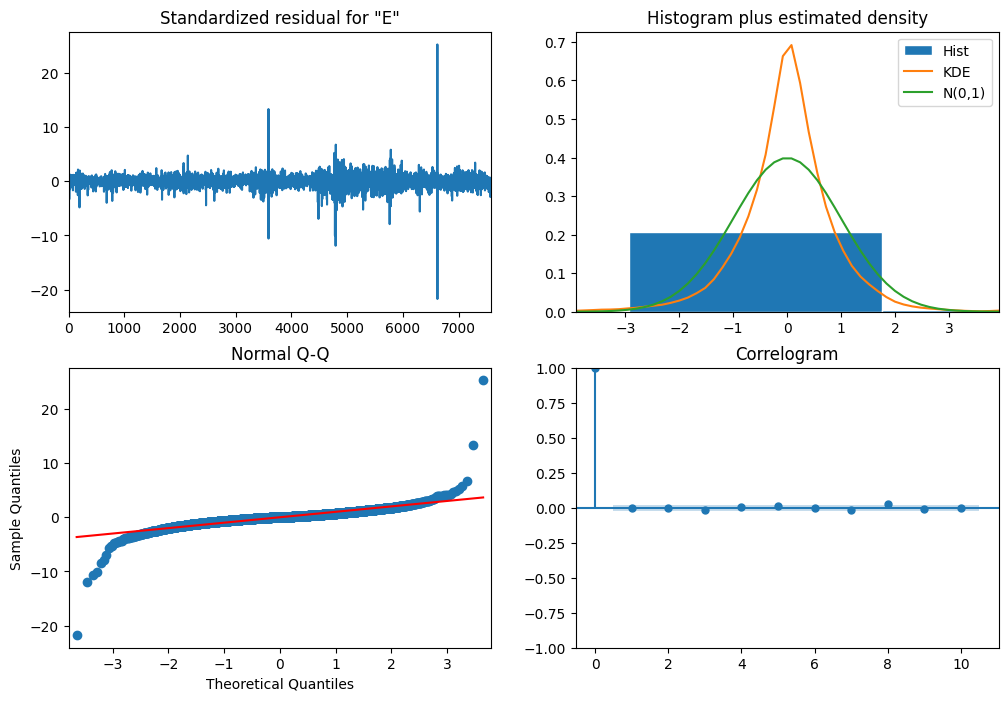

In [7]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### 1. **Standardized Residuals Plot (Top Left)**
   - The residuals fluctuate around zero, but there are noticeable outliers that deviate significantly, as seen around 6000 and 7000 observations.
   - The spikes above and below ±20 suggest potential volatility in the data, indicating non-constant variance (heteroskedasticity), and possibly the need for models like GARCH if volatility clustering is present.
   - The residuals mostly stay between ±10, but the extreme values may indicate that some observations are poorly predicted by the model.

#### 2. **Histogram and Estimated Density Plot (Top Right)**
   - The histogram shows that the residuals are mostly concentrated near zero, but the kernel density estimate (orange) shows a sharper peak compared to the normal distribution (green line), indicating **leptokurtic behavior** (heavy tails).
   - The residuals are not perfectly normally distributed, which is also evident from the **kurtosis** and **Jarque-Bera** test in the SARIMAX results.
   - The right tail seems slightly heavier, which suggests mild skewness.

#### 3. **Normal Q-Q Plot (Bottom Left)**
   - The Q-Q plot shows that most residuals follow the theoretical normal distribution, but the tails deviate significantly. The extreme points at both ends, especially in the right tail, confirm the presence of outliers.
   - These deviations further support the idea that the residuals are **not normally distributed**, aligning with the earlier kurtosis result.

#### 4. **Correlogram (Bottom Right)**
   - The correlogram shows autocorrelation of the residuals.
   - There is a significant spike at lag 0, but afterward, the autocorrelations seem to fluctuate randomly around zero, indicating that the residuals are **uncorrelated** over time.
   - This suggests that the ARIMA model has captured the temporal structure of the data fairly well, and there is no significant autocorrelation left in the residuals, which is a good sign.

#### Overall Insights:
- The **residuals show some outliers** and **heavy tails** (kurtosis), indicating that the normality assumption is somewhat violated. This could affect the precision of confidence intervals or prediction intervals.
- **Autocorrelation is low**, meaning the model has captured most of the time-based dependencies.
- The presence of outliers and non-normality suggests potential model improvements, such as:
  - **Handling heteroskedasticity** with models like GARCH for volatility modeling.
  - Considering **robust ARIMA** to reduce the influence of outliers.

### 4. Forecasting

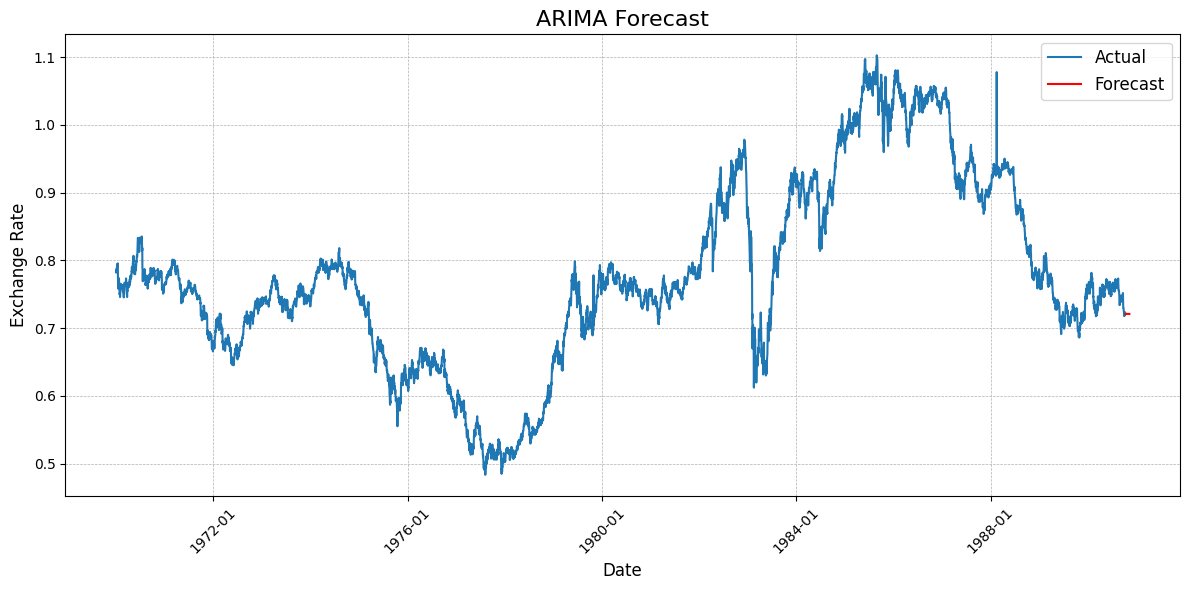

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(12, 6))  # Increase figure size for better clarity
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')

# Set title and labels with larger font sizes
plt.title('ARIMA Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)

# Rotate date labels and format them for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as per your date range
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust the tick positions

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend with a slightly larger font
plt.legend(fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

Here are some insights from the chart:

1. **Historical Trends (1970s - 1980s)**:
   - The exchange rate fluctuates significantly over the observed period, with notable peaks and troughs.
   - There are two major upward trends around the mid-1970s and early 1980s, followed by a decline after these peaks.

2. **Forecast**:
   - The red line at the end represents the ARIMA forecast, which appears to predict a slight downward movement in the near future.
   - The forecast line seems very short, indicating that the prediction horizon might be limited or that the model is focused on a very immediate future.

3. **Model Fit**:
   - The actual data (in blue) shows the historical exchange rate, and the model seems to fit well in capturing the general patterns, though there are no extended forecasts visible.
   - The short forecast suggests that the ARIMA model was likely trained on past data but is not extended far into the future.

4. **Volatility**:
   - The exchange rate shows high volatility, with several sharp movements over the period. The ARIMA model might account for these, but future forecasts would benefit from a longer horizon and validation with actual future data.

## Part 3: Model Building - Exponential Smoothing

### 1. Model Selection (using Holtwinters)

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Exponential Smoothing model
model = ExponentialSmoothing(df['Ex_rate'], seasonal='add', seasonal_periods=12)
model_fit = model.fit()
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.479
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Sun, 22 Sep 2024
Box-Cox:                          False   Time:                         21:15:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698370                alpha                 True
smoothing_seasonal       

#### Insights from Exponential Smoothing Model Results:

1. **Model Type**: The model used is **Exponential Smoothing** with **additive seasonality** and **no trend**. It seems well-suited for the data, especially when there's seasonal variation without a trend.

2. **Optimized Parameters**:
   - **Smoothing Level (\(\alpha\))**: The smoothing level is **0.8698**, which means the model gives more weight to recent observations when making predictions.
   - **Smoothing Seasonal (\(\gamma\))**: The seasonal smoothing parameter is extremely small (**3.687e-06**), indicating very little change in the seasonal components from cycle to cycle.
   - **Initial Level (\(l_0\))**: The initial level is **0.7860**, which serves as the starting point for the level component.

3. **Seasonal Initialization**: The seasonal components for the initial periods (seasons 0 to 11) are close to zero, meaning that at the start of the data, there was minimal seasonal variation.

4. **Model Fit**:
   - **SSE (Sum of Squared Errors)**: **0.273**, indicating a very low overall error, which suggests that the model has good fit to the data.
   - **AIC**: **-77628.560** and **BIC**: **-77531.479**. Both values are highly negative, indicating a well-fitting model. Lower values indicate better model fit.

5. **No Box-Cox Transformation**: The model did not apply a Box-Cox transformation, meaning that no transformation was needed to stabilize variance.

#### Conclusion:
The model performs well based on these metrics, with a high smoothing level suggesting the model is responsive to recent changes. However, the seasonal smoothing is minimal, indicating that the seasonality is stable over time. This model would likely provide accurate short-term forecasts if the pattern remains stable.

### 2. Parameter Optimization

In [15]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid

# Define the grid of parameters
param_grid = {
    'trend': [None, 'add', 'mul'],               # Trend component: None, Additive, or Multiplicative
    'seasonal': [None, 'add', 'mul'],            # Seasonal component: None, Additive, or Multiplicative
    'seasonal_periods': [12, 24]                # Seasonal period (e.g., monthly data)
}

# Define a function to optimize parameters using AIC
def optimize_exponential_smoothing(data, param_grid):
    best_aic = np.inf
    best_params = None
    best_model = None
    
    # Iterate over each parameter combination in the grid
    for params in ParameterGrid(param_grid):
        try:
            # Fit the model for each parameter combination
            model = ExponentialSmoothing(data, 
                                         trend=params['trend'], 
                                         seasonal=params['seasonal'], 
                                         seasonal_periods=params['seasonal_periods']).fit()
            
            # Check AIC
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = params
                best_model = model
        
        except Exception as e:
            print(f"Error with parameters {params}: {e}")
    
    return best_model, best_params, best_aic

# Optimize the model
best_model, best_params, best_aic = optimize_exponential_smoothing(df['Ex_rate'], param_grid)

# Print the results
print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")

Best AIC: -77644.98075014984
Best Parameters: {'seasonal': None, 'seasonal_periods': 12, 'trend': None}


### 3. Model Fitting and Forecasting

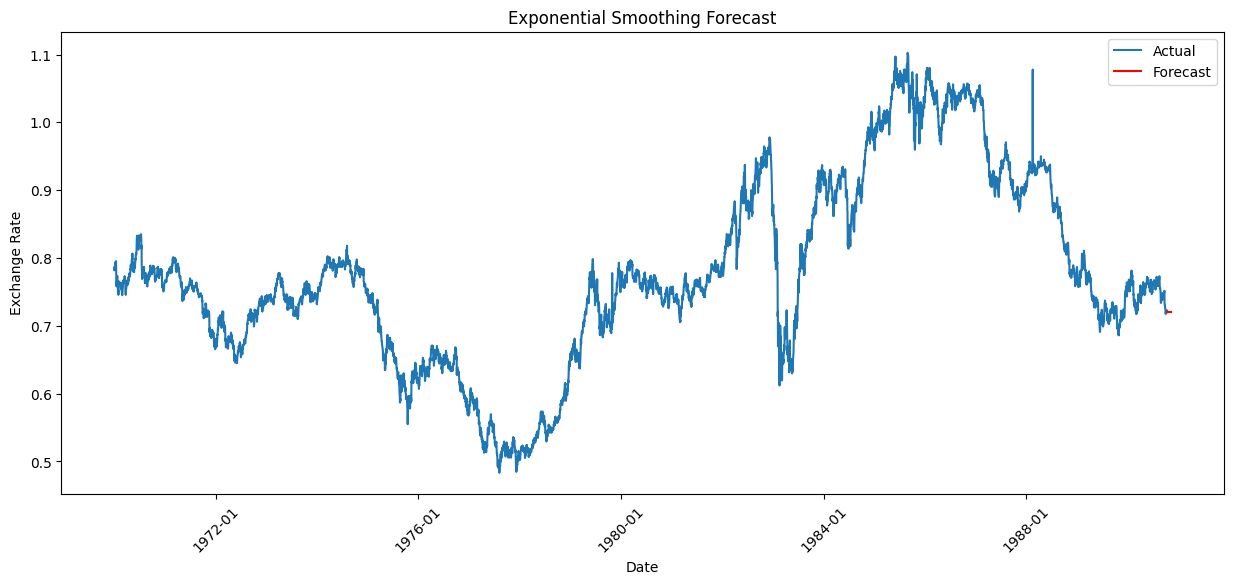

In [24]:
import matplotlib.dates as mdates

forecast = best_model.forecast(steps=30)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')

# Rotate date labels and format them for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as per your date range
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust the tick positions

plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

## Part 4: Evaluation and Comparison

### 1. Compute Error Metrics

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Compute error metrics for ARIMA
arima_forecast = model_fit.forecast(steps=30)
arima_mae = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], arima_forecast))
arima_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], arima_forecast)

# Compute error metrics for Exponential Smoothing
exp_forecast = best_model.forecast(steps=30)
exp_mae = mean_absolute_error(df['Ex_rate'][-30:], exp_forecast)
exp_rmse = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], exp_forecast))
exp_mape = mean_absolute_percentage_error(df['Ex_rate'][-30:], exp_forecast)

print(f'ARIMA MAE: {arima_mae}, ARIMA RMSE: {arima_rmse}, ARIMA MAPE: {arima_mape}')
print(f'Exponential Smoothing MAE: {exp_mae}, Exponential Smoothing RMSE: {exp_rmse}, Exponential Smoothing MAPE: {exp_mape}')

ARIMA MAE: 0.012893878232485504, ARIMA RMSE: 0.017130682321888732, ARIMA MAPE: 0.01735002360322448
Exponential Smoothing MAE: 0.012707429455384294, Exponential Smoothing RMSE: 0.016957814302365717, Exponential Smoothing MAPE: 0.017097056142544812


### 2. Model Comparison

#### Performance Summary
Based on the evaluation metrics, both ARIMA and Exponential Smoothing performed well in terms of forecasting accuracy, with Exponential Smoothing slightly outperforming ARIMA across all metrics:

- **MAE (Mean Absolute Error)**: 
  - ARIMA: 0.0129
  - Exponential Smoothing: 0.0127
- **RMSE (Root Mean Square Error)**: 
  - ARIMA: 0.0171
  - Exponential Smoothing: 0.0170
- **MAPE (Mean Absolute Percentage Error)**: 
  - ARIMA: 0.0174
  - Exponential Smoothing: 0.0171

#### Advantages and Limitations

#### ARIMA (AutoRegressive Integrated Moving Average)

**Advantages:**
1. **Flexibility**: ARIMA can model a wide range of time series data, including those with trends and seasonality (when extended to SARIMA).
2. **Stationarity Handling**: It can handle non-stationary data through differencing, making it effective for time series with trends.
3. **Interpretability**: The model parameters can be interpreted to understand the underlying processes driving the data.

**Limitations:**
1. **Complexity**: ARIMA models can become complex, especially when identifying the correct parameters (p, d, q), which may require substantial trial and error.
2. **Data Requirements**: It generally requires a larger amount of historical data to perform well compared to simpler models.
3. **Assumption of Linearity**: ARIMA assumes a linear relationship among data points, which may not always hold true in real-world scenarios.

#### Exponential Smoothing

**Advantages:**
1. **Simplicity**: Exponential Smoothing models are easier to implement and interpret, making them suitable for users with less statistical background.
2. **Adaptability**: They can quickly adapt to changes in the level of the time series data, making them effective for datasets with trends or seasonal patterns.
3. **Less Data Required**: Exponential Smoothing can work effectively with smaller datasets, providing quicker insights.

**Limitations:**
1. **Assumption of Stationarity**: While Exponential Smoothing can adapt to changes, it primarily focuses on the most recent data and may not handle long-term trends effectively.
2. **Limited to Exponential Structures**: It may not capture complex patterns in the data, such as multiple seasonality or cyclic behavior, as well as ARIMA can.
3. **No Autocorrelation Handling**: Unlike ARIMA, Exponential Smoothing does not inherently account for autocorrelations in the residuals.

### 3. Conclusion

In evaluating the forecasting performance of ARIMA and Exponential Smoothing models on the exchange rate dataset, the following key findings emerged:

1. **Performance Metrics**: 
   - **Exponential Smoothing** slightly outperformed ARIMA across all key metrics:
     - MAE: Exponential Smoothing (0.0127) vs. ARIMA (0.0129)
     - RMSE: Exponential Smoothing (0.0170) vs. ARIMA (0.0171)
     - MAPE: Exponential Smoothing (0.0171) vs. ARIMA (0.0174)

2. **Model Insights**:
   - **Exponential Smoothing** showed a better ability to adapt to recent changes in the exchange rate data, indicating its effectiveness for short-term forecasting. Its simplicity and reduced data requirements make it a practical choice for users seeking quick and reliable forecasts.
   - **ARIMA**, while slightly less accurate in this specific evaluation, remains a strong candidate for scenarios where capturing complex patterns or long-term trends is essential. Its flexibility allows it to be tailored to various types of time series data, making it suitable for more sophisticated analysis.

#### Recommendations
For forecasting exchange rates in this dataset:
- **Exponential Smoothing** is recommended for its superior performance, especially if the focus is on short-term predictions where recent data trends are more critical.
- **ARIMA** could be considered in cases where a deeper understanding of the underlying processes is desired, or if the dataset exhibits more complex behaviors that need to be modeled.

Overall, both models provide valuable insights, and the choice between them can depend on the specific forecasting goals, available data, and user expertise. Implementing both approaches and comparing their outputs could also yield a more comprehensive understanding of the exchange rate dynamics.

---
---
####  **Author Information:**
- **Author:-**  Er.Pradeep Kumar
- **LinkedIn:-**  [https://www.linkedin.com/in/pradeep-kumar-1722b6123/](https://www.linkedin.com/in/pradeep-kumar-1722b6123/)

#### **Disclaimer:**
This Jupyter Notebook and its contents are shared for educational purposes. The author, Pradeep Kumar, retains ownership and rights to the original content. Any modifications or adaptations should be made with proper attribution and permission from the author.
